In [1]:
import pandas as pd
import numpy as np
import datetime
import os
import matplotlib.pyplot as plt
import seaborn as sns
import itertools as it
import scipy.stats as sp
from scipy.stats import chi2_contingency
from scipy.stats import chi2
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules

In [2]:
print('> Reading raw data:')
df = pd.read_csv('./final.csv')
print(df.head())

> Reading raw data:
   id  rows  columns  categorical  continuous  targated  k-accuracy   k-f1  \
0   1  3524       32           18           5         2       0.604  0.561   
1   2  3524       31           17           5         2       0.581  0.539   
2   3  3524       29           16           4         2       0.605  0.371   
3   4  3524       28           15           4         2       0.578  0.537   
4   5  3524       28           16           3         2       0.645  0.550   

   rf-accuracy  rf-f1  ada-accuracy  ada-f1  gb-accuracy  gb-f1  best  
0        0.669  0.654         0.709   0.698        0.684  0.663     3  
1        0.692  0.667         0.666   0.633        0.690  0.648     2  
2        0.674  0.593         0.644   0.574        0.696  0.608     4  
3        0.677  0.625         0.654   0.609        0.657  0.592     2  
4        0.699  0.642         0.701   0.660        0.717  0.667     4  


In [3]:
corr_df = df[['rows','columns','categorical','continuous','targated']].corr()

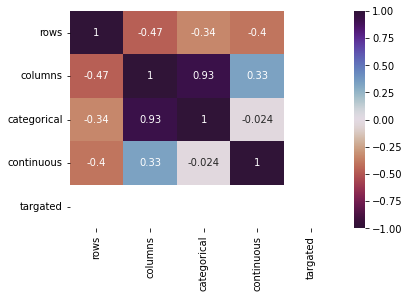

In [4]:
sns.heatmap(corr_df, vmin=-1, vmax=1, cmap='twilight_shifted_r', annot=True);

In [5]:
cov_df = df[['rows','columns','categorical','continuous','targated']].cov()
cov_df

,rows,columns,categorical,continuous,targated
rows,770534.696970,-1902.590909,-1568.803030,-467.303030,0.0
columns,-1902.590909,21.295455,22.613636,2.045455,0.0
categorical,-1568.803030,22.613636,27.901515,-0.166667,0.0
continuous,-467.303030,2.045455,-0.166667,1.787879,0.0
targated,0.000000,0.000000,0.000000,0.000000,0.0


In [6]:
df.shape

(12, 15)

In [7]:
df.head()

,id,rows,columns,categorical,continuous,targated,k-accuracy,k-f1,rf-accuracy,rf-f1,ada-accuracy,ada-f1,gb-accuracy,gb-f1,best
0,1,3524,32,18,5,2,0.604,0.561,0.669,0.654,0.709,0.698,0.684,0.663,3
1,2,3524,31,17,5,2,0.581,0.539,0.692,0.667,0.666,0.633,0.690,0.648,2
2,3,3524,29,16,4,2,0.605,0.371,0.674,0.593,0.644,0.574,0.696,0.608,4
3,4,3524,28,15,4,2,0.578,0.537,0.677,0.625,0.654,0.609,0.657,0.592,2
4,5,3524,28,16,3,2,0.645,0.550,0.699,0.642,0.701,0.660,0.717,0.667,4


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12 entries, 0 to 11
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   id            12 non-null     int64  
 1   rows          12 non-null     int64  
 2   columns       12 non-null     int64  
 3   categorical   12 non-null     int64  
 4   continuous    12 non-null     int64  
 5   targated      12 non-null     int64  
 6   k-accuracy    12 non-null     float64
 7   k-f1          12 non-null     float64
 8   rf-accuracy   12 non-null     float64
 9   rf-f1         12 non-null     float64
 10  ada-accuracy  12 non-null     float64
 11  ada-f1        12 non-null     float64
 12  gb-accuracy   12 non-null     float64
 13  gb-f1         12 non-null     float64
 14  best          12 non-null     int64  
dtypes: float64(8), int64(7)
memory usage: 1.5 KB


In [9]:
df.isnull().sum()

id              0
rows            0
columns         0
categorical     0
continuous      0
targated        0
k-accuracy      0
k-f1            0
rf-accuracy     0
rf-f1           0
ada-accuracy    0
ada-f1          0
gb-accuracy     0
gb-f1           0
best            0
dtype: int64

In [10]:
df.describe()   # before replacing zero with None

,id,rows,columns,categorical,continuous,targated,k-accuracy,k-f1,rf-accuracy,rf-f1,ada-accuracy,ada-f1,gb-accuracy,gb-f1,best
count,12.000000,12.000000,12.0000,12.000000,12.000000,12.0,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000
mean,6.500000,3156.833333,27.2500,14.083333,3.833333,2.0,0.598583,0.508750,0.665333,0.609667,0.663167,0.608750,0.671083,0.610167,3.000000
std,3.605551,877.801058,4.6147,5.282188,1.337116,0.0,0.037944,0.065799,0.045187,0.054540,0.049280,0.064927,0.056971,0.078178,0.953463
min,1.000000,881.000000,18.0000,0.000000,1.000000,2.0,0.528000,0.371000,0.565000,0.501000,0.549000,0.485000,0.542000,0.441000,2.000000
25%,3.750000,3524.000000,24.5000,11.750000,3.000000,2.0,0.575250,0.462500,0.666750,0.588750,0.650000,0.568750,0.654250,0.586750,2.000000
50%,6.500000,3524.000000,28.0000,16.000000,4.000000,2.0,0.600000,0.538000,0.673500,0.634000,0.666500,0.613500,0.682500,0.622000,3.000000
75%,9.250000,3524.000000,31.2500,18.000000,5.000000,2.0,0.620000,0.552750,0.693750,0.641250,0.698750,0.649500,0.701000,0.657750,4.000000
max,12.000000,3524.000000,32.0000,18.000000,5.000000,2.0,0.665000,0.588000,0.716000,0.667000,0.736000,0.698000,0.761000,0.731000,4.000000


In [11]:
continuous_features=['rows','columns','categorical','continuous','k-f1','rf-f1','ada-f1','gb-f1']
target_features=['best']
all_features = continuous_features + target_features

In [12]:
corr_df=df[all_features].corr()
corr_df

,rows,columns,categorical,continuous,k-f1,rf-f1,ada-f1,gb-f1,best
rows,1.000000,-4.696841e-01,-0.338344,-0.398138,0.132648,-0.245410,-0.249222,-0.274620,9.558511e-02
columns,-0.469684,1.000000e+00,0.927712,0.331495,-0.004865,0.522658,0.507845,0.414898,1.101062e-16
categorical,-0.338344,9.277117e-01,1.000000,-0.023597,-0.124177,0.315978,0.345460,0.222310,9.025261e-02
continuous,-0.398138,3.314953e-01,-0.023597,1.000000,0.323935,0.723438,0.621492,0.689938,-7.130740e-02
k-f1,0.132648,-4.865186e-03,-0.124177,0.323935,1.000000,0.433056,0.565004,0.501987,9.708692e-02
rf-f1,-0.245410,5.226581e-01,0.315978,0.723438,0.433056,1.000000,0.882109,0.878079,2.150275e-01
ada-f1,-0.249222,5.078449e-01,0.345460,0.621492,0.565004,0.882109,1.000000,0.948496,4.390879e-01
gb-f1,-0.274620,4.148981e-01,0.222310,0.689938,0.501987,0.878079,0.948496,1.000000,5.341874e-01
best,0.095585,1.101062e-16,0.090253,-0.071307,0.097087,0.215028,0.439088,0.534187,1.000000e+00


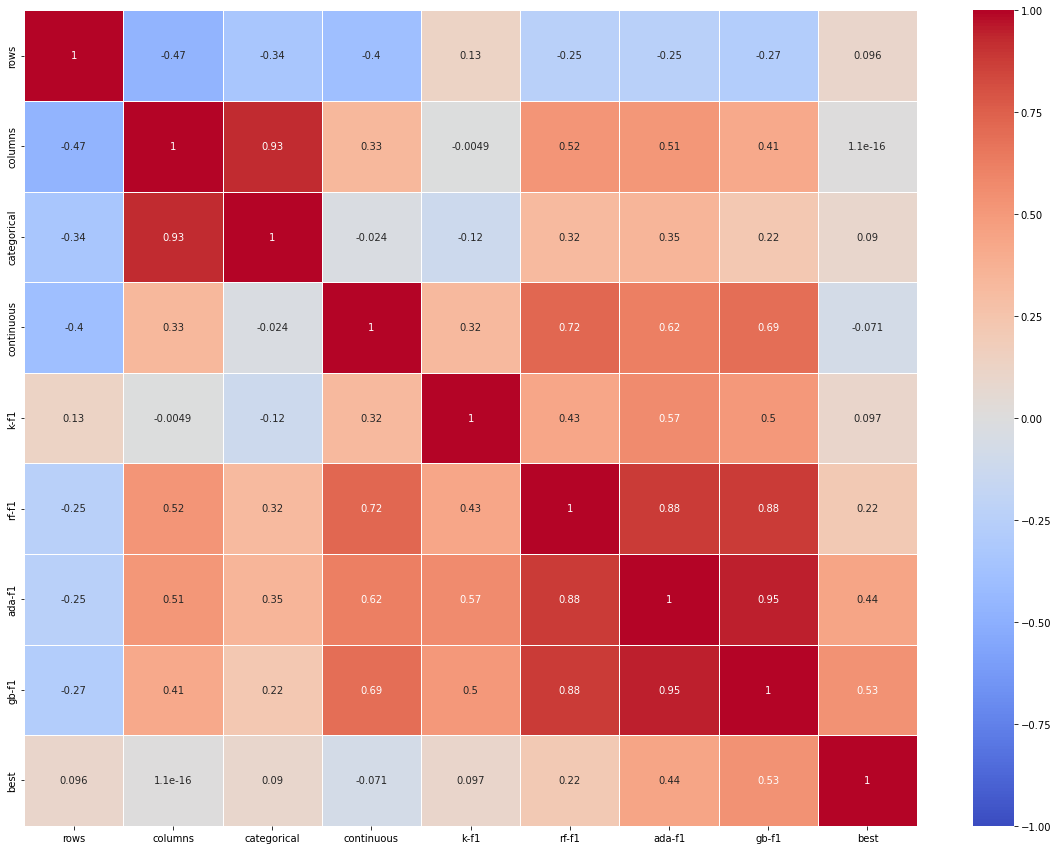

In [13]:
plt.figure(figsize=(20,15))
sns.heatmap(corr_df,cmap='coolwarm',vmin=-1, vmax=1,annot=True,linewidth=.5);


In [21]:
corr_df_features = set()
for i in range(len(corr_df.columns)-5):
    if corr_df.iloc[i,4]<-0.04 or corr_df.iloc[i,4]>0.04 or corr_df.iloc[i,5]<-0.04 or corr_df.iloc[i,5]>0.04 or corr_df.iloc[i,6]<-0.04 or corr_df.iloc[i,6]>0.04 or corr_df.iloc[i,7]<-0.04 or corr_df.iloc[i,7]>0.04:
        corr_df_features.add(corr_df.columns[i])

In [22]:
corr_df_features

{'categorical', 'columns', 'continuous', 'rows'}

In [16]:
df[list(corr_df_features)+['k-f1','rf-f1','ada-f1','gb-f1','columns','best']].to_csv('final_training_data.csv')